In [1]:
#Projet Mogpl M1 Informatique
#Dice Battle

#Yuhan WANG & Yufei LIU

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pygame
import sys

#variable global N est le point cible et D est le nombre de dés qu'on peut lancer maximument chaque fois
#LP = ligne perdu signifie que si joueur1 a moins de cette ligne et joueur 2 a N-1 point alors joueur1 a perdu
N = 100
D = 10
LP = N - 6*D

#Q1
def initialise_tab(d):
    """
    entrée : le nombre de dés
    sortie : Q_tab et P_tab initialisé
    """
    Q_tab=np.ones((D+1,101))*-1
    
    for a in range(0,101):
        Q_tab[0,a]=0
    for b in range(0,D+1):
        Q_tab[b,0]=0
    for i in range (2,7):
        #la propabilité d'obtenir 1 avec d dés
        Q_tab[1,i]=1/5
    
    P_tab=np.ones((D+1,101))*-2
    for c in range(0,D+1):
        P_tab[c,0]=0
        P_tab[c,1]=1-np.power(5/6,c)
    for d in range(0,101):
        P_tab[0,d]=0
        
        
    return Q_tab,P_tab  

Q_tab=initialise_tab(D)[0]
P_tab= initialise_tab(D)[1]

def Q(d,k):
    if d<=0:
        return 0
    if k<=0 | ((k>1) & (k<2*d)) | k>6*d :
        return 0
    else:
        if(Q_tab[d,k]!=-1):
            #print(d,k,Q_tab[d,k])
            return Q_tab[d,k]
        else:
            res = 0
            for j in range(2,7):
                #print(d-1,k-j)
                if(Q_tab[d-1,k-j]==-1):
                    Q_tab[d-1,k-j]=Q(d-1,k-j)
                res += Q(d-1,k-j)
            return res/5
        
        
def P(d,k):
    if(k==1):
        return P_tab[d,1]
    if P_tab[d,k]!=-2:
        return P_tab[d,k]
    else:
        P_tab[d,k]=(5/6)**d*Q(d,k)
        return P_tab[d,k]

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
#Q2

def calcul_EP(d):
    return 4*d*(5/6)**d + 1 - (5/6)**d

print(calcul_EP(5))
print(calcul_EP(6))
#On doit choisir d*=6 car EP(6) est supérieur de EP(5)




8.63567386831276
8.702653463648836


In [4]:
class strategie_optimal(object):
    def __init__(self, D, N):
        self.N = N
        self.D = D
        self.tab = np.ones((N,N))*100
        self.best_choice = np.zeros((N,N))
         
    def EG(self,i,j):
        if(i>=self.N):
            return 1
        elif(j>=self.N):
            return -1
        elif self.tab[i][j]<100:
            return self.tab[i][j]
        
        exps=[]
        for d1 in range(1,self.D+1):
            exp=0
            for e1 in range(1,6*d1+1):
                exp += P(d1,e1) * self.EG(j,i+e1)
            exps.append(-exp)
        self.tab[i][j]=max(exps)
        self.best_choice[i][j]=int(np.argmax(exps)+1)
        return self.tab[i][j]
    
    def choice_optimal(self,i,j):
        if self.best_choice[i][j]<1:
            t = self.EG(i,j)
        return self.best_choice[i][j]
    

In [5]:
#Q7
class strategie_aveugle(object):
    def __init__(self, D, N):
        self.N = N
        self.D = D
        
    def choice_optimal(self,i,j):
        if self.D > 5:
            return 6
        return self.D
    
stra_opt1 = strategie_optimal(10,100)
stra_opt1 = strategie_optimal(10,100)
#def strategie_optimale(i,j):


In [6]:
#Q8
def get_random_score(d):
    res = 0
    for i in range(d):
        tmp = random.randint(1 , 6)
        if(tmp==1):
            return 1
        res += tmp
    return res


def game_ai(n,stra1,stra2):
    state=[0,0]
    while(state[1]<n)&(state[0]<n):
        #print("Score of player1: ",state[0],"\n Score of player2: ",state[1],"\n")
        d1 = int(stra1.choice_optimal(state[0],state[1]))
        p1 = get_random_score(d1)
        state[0] += p1
        #print("AI111 get ",p1, "score with ",d1," dice(s)!\n")
        if(state[0]>=n):
            return 1
        d2 = int(stra2.choice_optimal(state[1],state[0]))
        p2 = get_random_score(d2)
        state[1] += p2
        #print("AI222 get ",p2, "score with ",d2," dice(s)!\n")
    if state[0]>=n:
        return 1
    else:
        return -1

        

def test_D(D,N):
    n_test = 50
    n_intervalle = 10
    ds = [ int(D*i/n_intervalle) for i in range(1,1+n_intervalle)]
    res = np.zeros((4,n_intervalle))
    #res = [aa,ao,oa,oo]
    for di in range(len(ds)):
        res_aa = 0
        res_ao = 0
        res_oa = 0
        res_oo = 0
        stra_opt = strategie_optimal(ds[di],N)
        stra_avg = strategie_aveugle(ds[di],N)
        for i in range(n_test):
            res_aa += game_ai(N,stra_avg,stra_avg)
            res_ao += game_ai(N,stra_avg,stra_opt)
            res_oa += game_ai(N,stra_opt,stra_avg)
            res_oo += game_ai(N,stra_opt,stra_opt)
            
        res[0][di] = res_aa / n_test
        res[1][di] = res_ao / n_test
        res[2][di] = res_oa / n_test
        res[3][di] = res_oo / n_test
        
    plt.plot(ds , res[0], c='r')
    plt.xlabel("nombre de dé possible")
    plt.ylabel("variance de gain J1")
    plt.title("J1 aveugle & J2 aveugle")
    plt.show()
    
    plt.plot(ds , res[1], c='blue')
    plt.xlabel("nombre de dé possible")
    plt.ylabel("variance de gain J1")
    plt.title("J1 aveugle & J2 optimal")
    plt.show()
    
    plt.plot(ds , res[2], c='y')
    plt.xlabel("nombre de dé possible")
    plt.ylabel("variance de gain J1")
    plt.title("J1 optimal & J2 aveugle")
    plt.show()
    
    plt.plot(ds , res[3], c='black')
    plt.xlabel("nombre de dé possible")
    plt.ylabel("variance de gain J1")
    plt.title("J1 optimal & J2 optimal")
    plt.show()
    return res
    

    
def test_N(D,N):
    n_test = 50
    n_intervalle = 10
    ns = [ int(N*i/n_intervalle) for i in range(1,1+n_intervalle)]
    res = np.zeros((4,n_intervalle))
    #res = [aa,ao,oa,oo]
    for ni in range(len(ns)):
        res_aa = 0
        res_ao = 0
        res_oa = 0
        res_oo = 0
        stra_opt = strategie_optimal(D,ns[ni])
        stra_avg = strategie_aveugle(D,ns[ni])
        for i in range(n_test):
            res_aa += game_ai(ns[ni],stra_avg,stra_avg)
            res_ao += game_ai(ns[ni],stra_avg,stra_opt)
            res_oa += game_ai(ns[ni],stra_opt,stra_avg)
            res_oo += game_ai(ns[ni],stra_opt,stra_opt)
            
        res[0][ni] = res_aa / n_test
        res[1][ni] = res_ao / n_test
        res[2][ni] = res_oa / n_test
        res[3][ni] = res_oo / n_test
        
    plt.plot(ns , res[0], c='r')
    plt.xlabel("ligne N pour gagner")
    plt.ylabel("variance de gain J1")
    plt.title("J1 aveugle & J2 aveugle")
    plt.show()
    
    plt.plot(ns , res[1], c='blue')
    plt.xlabel("ligne N pour gagner")
    plt.ylabel("variance de gain J1")
    plt.title("J1 aveugle & J2 optimal")
    plt.show()
    
    plt.plot(ns , res[2], c='y')
    plt.xlabel("ligne N pour gagner")
    plt.ylabel("variance de gain J1")
    plt.title("J1 optimal & J2 aveugle")
    plt.show()
    
    plt.plot(ns , res[3], c='black')
    plt.xlabel("ligne N pour gagner")
    plt.ylabel("variance de gain J1")
    plt.title("J1 optimal & J2 optimal")
    plt.show()
    return res

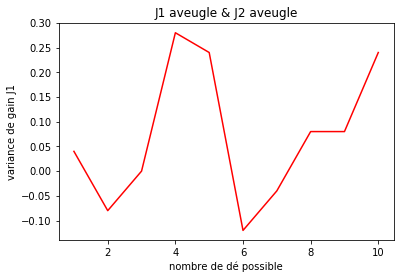

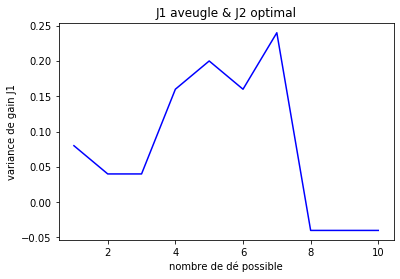

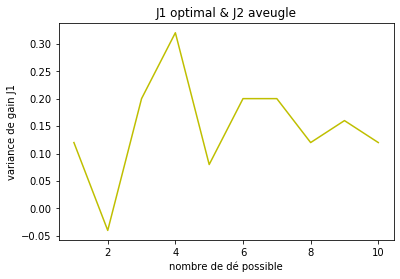

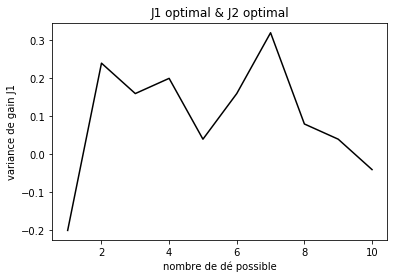

array([[ 0.04, -0.08,  0.  ,  0.28,  0.24, -0.12, -0.04,  0.08,  0.08,
         0.24],
       [ 0.08,  0.04,  0.04,  0.16,  0.2 ,  0.16,  0.24, -0.04, -0.04,
        -0.04],
       [ 0.12, -0.04,  0.2 ,  0.32,  0.08,  0.2 ,  0.2 ,  0.12,  0.16,
         0.12],
       [-0.2 ,  0.24,  0.16,  0.2 ,  0.04,  0.16,  0.32,  0.08,  0.04,
        -0.04]])

In [14]:
test_D(10,100)

In [ ]:
test_N(10,100)

In [9]:
#print(stra_opt1.EG(95,95))
[stra_opt1.EG(i,99) for i in range(0,100)]
print(stra_opt1.EG(0,0))

0.06871904732303523


In [10]:
#Q9
class game(object):
    def __init__(self, D, N):
        self.N = N
        self.D = D
        self.tab = np.ones((N,N))*100
        
    
    def start_conter_ai(self,strategie):
        state=[0,0]
        tour = 0
        while(state[1]<self.N)&(state[0]<self.N):
            tour += 1
            print("*****************************************\n")
            print("Tour:",tour, "\n Score of player1: ",state[0],"\n Score of player2: ",state[1],"\n Score of target: ",self.N )
            print("You can make a choice between 1 and ",self.D," for this round:")
            d1 = int(input())
            p1 = get_random_score(d1)
            print("You get ",p1, "score with ",d1, " dice(s)!\n")
            state[0]+=p1
            if(state[0]>=n):
                break
            d2 = int(strategie.choice_optimal(state[1],state[0]))
            p2 = get_random_score(d2)
            print("AI get ",p2, "score with ",d2," dice(s)!\n")
            state[1]+=p2
            print("\n\n\n\n\n\n")
            
        if state[0]>=self.N:
            print("You win")
        else:
            print("•••You lose•••")
            
    def start(self):
        pygame.init()
        screen = pygame.display.set_mode((640,480),0,32)
        pygame.display.set_caption("Dice Battle")
        dice = pygame.image.load("img/dice_0.jpg")
        print(dice)
        dice_x, dice_y = 0, 0  
        h_direction = 1  
        speed = 10
        width = 844
        while 1:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
            
            screen.blit(dice, (dice_x, dice_y))
            dice_x += speed * h_direction
            if dice_x > width:
                h_direction = -h_direction
            elif dice_x < 0:
                h_direction = -h_direction
            pygame.display.update()
            

        



In [11]:
game1 = game(10,100)
#game1.start_conter_ai(stra_opt1)

In [12]:
game2 = game(10,100)
#game2.start()


In [13]:
stra_opt1 = strategie_optimal(10,200)
stra_opt2 = strategie_optimal(10,200)
print(sum([game_ai(200,stra_opt1,stra_opt2) for i in range(100)]))


-6
